In [25]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.optimize as spopt
import scipy.linalg
import scipy.fft as spfft
# import scipy.ndimage as spimg
import cvxpy as cvx

In [35]:
N = 1000
t = np.linspace(0, np.pi, N)
x = np.sum([np.sin(2*np.pi*f*t + 2*np.pi/f) for f in [1,3,5]], axis=0)

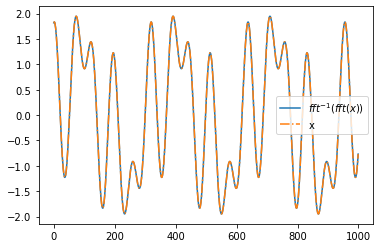

In [62]:
y = spfft.ifft(spfft.fft(x))
plt.plot(y.real, label=r'$fft^{-1}(fft(x))$')
plt.plot(x, '-.', label='x')
plt.legend()

dif of max 3891.614441289554


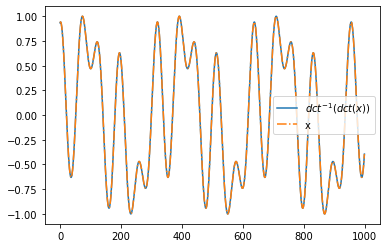

In [63]:
y = spfft.idct(spfft.dct(x))
print('dif of max', y.max() - x.max())
plt.plot(y / y.max(), label=r'$dct^{-1}(dct(x))$')
plt.plot(x / x.max(), '-.', label='x')
plt.legend()

In [16]:
dft = lambda N: N**2
fft = lambda N: N * np.log2(N)
for i in np.arange(1, 6):
    N = 10**i
    print('N: 10^%i, \tdft: 10^%i\tfft: 10^%i' % (N, np.log10(dft(N)), np.log10(fft(N))))

N: 10^10, 	dft: 10^2	fft: 10^1
N: 10^100, 	dft: 10^4	fft: 10^2
N: 10^1000, 	dft: 10^6	fft: 10^3
N: 10^10000, 	dft: 10^8	fft: 10^5
N: 10^100000, 	dft: 10^10	fft: 10^6


In [32]:
# O(MC) == O(dft) = O(NM), but accuracy is higher
fft = lambda N: N * np.log2(N)
print('O(fft) == O(dft)\n')
print('O \tN_fft \tN_MC \tacc(fft) \tacc(MC)')
for i in np.arange(3, 8):
    O = fft(10**i)
    print('10^%i \t10^%i \t 10^%i \t?\t\t?' % (np.log10(O), i, np.log10(np.sqrt(O))))

O(fft) == O(dft)

O 	N_fft 	N_MC 	acc(fft) 	acc(MC)
10^3 	10^3 	 10^1 	?		?
10^5 	10^4 	 10^2 	?		?
10^6 	10^5 	 10^3 	?		?
10^7 	10^6 	 10^3 	?		?
10^8 	10^7 	 10^4 	?		?


# Compressive sensing

Fourier decomposition using non-periodic samples

In [2]:
# how many samples are required for an estimate that is "just as" good as fft?

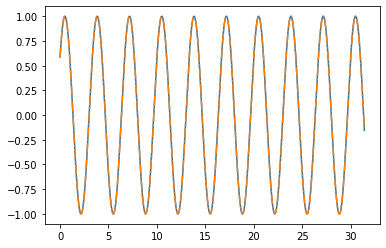

In [31]:
dt = 0.0001 * np.pi
N = int(1e5)
t = np.linspace(0, N * dt, N)
f, phi = 0.3, 0.2
x = np.sin(2*np.pi * f * t + phi * np.pi)

x_fft = spfft.fft(x)
x_ifft = spfft.ifft(x_fft)

plt.plot(t,x)
plt.plot(t, np.real(x_ifft), '-.')

In [48]:
# acc = np.zeros(N)
# for i in range(1000):
#     f = i / dt
#     acc += x_fft.real * np.sin(f * t * 2 * np.pi + x_fft.imag)

# plt.plot(acc)

In [52]:
# sum of two sinusoids
n = 5000
t = np.linspace(0, 1/8, n)
y = np.sin(1394 * np.pi * t) + np.sin(3266 * np.pi * t)
yt = spfft.dct(y, norm='ortho')

# extract small sample of signal
m = 500 # 10% sample
ri = np.random.choice(n, m, replace=False) # random sample of indices
ri.sort() # sorting not strictly necessary, but convenient for plotting
t2 = t[ri]
y2 = y[ri]

In [28]:
# create idct matrix operator
A = spfft.idct(np.identity(n), norm='ortho', axis=0)
A = A[ri]

# do L1 optimization
vx = cvx.Variable(n)
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [A*vx == y2]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True)

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 10000, constraints m = 10500
          nnz(P) + nnz(A) = 2519901
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -4.0000e+04   8.00e+00   9.36e+05   1.00e-01   9.67e-01s
 200   3.6273e+02   3.01e-02   3.94e-03   1.00e-01   2.11e+00s
 400   3.6276e+02   3.37e-02   4.99e-

In [50]:
# reconstruct signal

x = np.array(vx.value)
x = np.squeeze(x)
sig = spfft.idct(x, norm='ortho', axis=0)

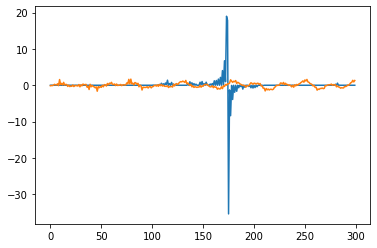

In [56]:
plt.plot(x[:300])
plt.plot(sig[:300])